In [1]:
import torch
from pathlib import Path

torch.manual_seed(1337)

In [2]:
REPO_ROOT = Path.cwd()
if (REPO_ROOT / "data").exists() is False and (REPO_ROOT.parent / "data").exists():
    REPO_ROOT = REPO_ROOT.parent

data_path = REPO_ROOT / "data" / "names.txt"
words = data_path.read_text(encoding="utf-8").splitlines()

print("repo root:", REPO_ROOT)
print("num words:", len(words))
print("first 5 words:", words[:5])

repo root: /Users/home/Developer/github/makemore-notes
num words: 32033
first 5 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
chars = sorted(set("".join(words)))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

print("vocab_size:", vocab_size)
print("itos sample:", list(itos.items())[:10])

vocab_size: 27
itos sample: [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f'), (7, 'g'), (8, 'h'), (9, 'i'), (10, 'j')]


In [4]:
block_size = 3  # number of characters used as context

def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(words, block_size)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: torch.Size([228146, 3])
Y shape: torch.Size([228146])


In [5]:
assert X.shape[0] == Y.shape[0]
assert X.shape[1] == block_size
assert X.dtype == torch.int64
assert Y.dtype == torch.int64
assert Y.min() >= 0 and Y.max() < vocab_size

In [6]:
def decode_context(ctx):
    return "".join(itos[int(i)] for i in ctx)

for i in [0, 1, 2, 3, 4, 20, 100]:
    print(
        f"{i:>5} | X = {decode_context(X[i])!r} -> Y = {itos[int(Y[i])]!r}"
    )

    0 | X = '...' -> Y = 'e'
    1 | X = '..e' -> Y = 'm'
    2 | X = '.em' -> Y = 'm'
    3 | X = 'emm' -> Y = 'a'
    4 | X = 'mma' -> Y = '.'
   20 | X = 'sab' -> Y = 'e'
  100 | X = 'lla' -> Y = '.'


In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

X = X.to(device)
Y = Y.to(device)

device: mps


In [8]:
g = torch.Generator(device=device).manual_seed(1337)

n_embed = 10     # embedding dimension
n_hidden = 200   # hidden layer width

In [9]:
# Embedding table: (vocab_size, n_embed)
C = torch.randn((vocab_size, n_embed), generator=g, device=device)

# First layer: takes block_size*n_embed -> n_hidden
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g, device=device) * (5/3) / (block_size * n_embed) ** 0.5
b1 = torch.randn((n_hidden,), generator=g, device=device) * 0.01

# Output layer: n_hidden -> vocab_size
W2 = torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.01
b2 = torch.zeros((vocab_size,), device=device)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_(True)

sum(p.nelement() for p in parameters)

11897

In [10]:
# minibatch for sanity (faster than full dataset)
batch_size = 32
ix = torch.randint(0, X.shape[0], (batch_size,), generator=g, device=device)

Xb, Yb = X[ix], Y[ix]  # (B, block_size), (B,)

# 1) embedding lookup: (B, block_size, n_embed)
emb = C[Xb]

# 2) concatenate embeddings: (B, block_size*n_embed)
emb_cat = emb.view(emb.shape[0], -1)

# 3) hidden layer
h_pre = emb_cat @ W1 + b1          # (B, n_hidden)
h = torch.tanh(h_pre)              # nonlinearity

# 4) logits
logits = h @ W2 + b2               # (B, vocab_size)

print("Xb:", Xb.shape)
print("emb:", emb.shape)
print("emb_cat:", emb_cat.shape)
print("h:", h.shape)
print("logits:", logits.shape)

Xb: torch.Size([32, 3])
emb: torch.Size([32, 3, 10])
emb_cat: torch.Size([32, 30])
h: torch.Size([32, 200])
logits: torch.Size([32, 27])


In [11]:
import torch.nn.functional as F

loss = F.cross_entropy(logits, Yb)
loss

tensor(3.3152, device='mps:0', grad_fn=<NllLossBackward0>)

In [12]:
assert logits.shape == (batch_size, vocab_size)
assert Yb.shape == (batch_size,)
assert torch.isfinite(loss).item() is True

In [13]:
# split dataset (reproducible shuffle)
g_cpu = torch.Generator().manual_seed(1337)
perm = torch.randperm(X.shape[0], generator=g_cpu)

X, Y = X[perm], Y[perm]

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])

Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xte, Yte = X[n2:], Y[n2:]

print(Xtr.shape, Xdev.shape, Xte.shape)

torch.Size([182516, 3]) torch.Size([22815, 3]) torch.Size([22815, 3])


In [14]:
def forward(Xb: torch.Tensor) -> torch.Tensor:
    # Xb: (B, block_size)
    emb = C[Xb]                           # (B, block_size, n_embed)
    emb_cat = emb.view(emb.shape[0], -1)  # (B, block_size*n_embed)
    h = torch.tanh(emb_cat @ W1 + b1)     # (B, n_hidden)
    logits = h @ W2 + b2                  # (B, vocab_size)
    return logits

In [15]:
max_steps = 20_000
batch_size = 256
eval_interval = 1_000

lr_start = 0.1
lr_end = 0.01

In [16]:
lossi = []

for step in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward
    logits = forward(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate schedule: linear decay
    t = step / (max_steps - 1)
    lr = lr_start * (1 - t) + lr_end * t

    # update (no .data)
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track
    if step % eval_interval == 0:
        lossi.append(loss.item())
        print(f"{step:>6}/{max_steps}  loss={loss.item():.4f}  lr={lr:.4f}")

     0/20000  loss=3.3101  lr=0.1000
  1000/20000  loss=2.1872  lr=0.0955
  2000/20000  loss=2.1808  lr=0.0910
  3000/20000  loss=2.1743  lr=0.0865
  4000/20000  loss=2.3240  lr=0.0820
  5000/20000  loss=2.1550  lr=0.0775
  6000/20000  loss=2.1988  lr=0.0730
  7000/20000  loss=2.2385  lr=0.0685
  8000/20000  loss=2.3100  lr=0.0640
  9000/20000  loss=2.2324  lr=0.0595
 10000/20000  loss=2.3109  lr=0.0550
 11000/20000  loss=2.0826  lr=0.0505
 12000/20000  loss=2.0908  lr=0.0460
 13000/20000  loss=2.0911  lr=0.0415
 14000/20000  loss=2.1032  lr=0.0370
 15000/20000  loss=2.0691  lr=0.0325
 16000/20000  loss=2.2252  lr=0.0280
 17000/20000  loss=2.1017  lr=0.0235
 18000/20000  loss=2.1412  lr=0.0190
 19000/20000  loss=2.0408  lr=0.0145


In [17]:
@torch.no_grad()
def split_loss(Xs: torch.Tensor, Ys: torch.Tensor, batch_size: int = 4096) -> float:
    # compute average loss in chunks to avoid memory spikes
    total_loss = 0.0
    total_n = 0
    for i in range(0, Xs.shape[0], batch_size):
        Xb = Xs[i:i+batch_size]
        Yb = Ys[i:i+batch_size]
        logits = forward(Xb)
        loss = F.cross_entropy(logits, Yb, reduction="sum")
        total_loss += loss.item()
        total_n += Yb.numel()
    return total_loss / total_n

train_loss = split_loss(Xtr, Ytr)
dev_loss = split_loss(Xdev, Ydev)

print(f"train loss: {train_loss:.4f}")
print(f"dev   loss: {dev_loss:.4f}")

train loss: 2.1260
dev   loss: 2.1498


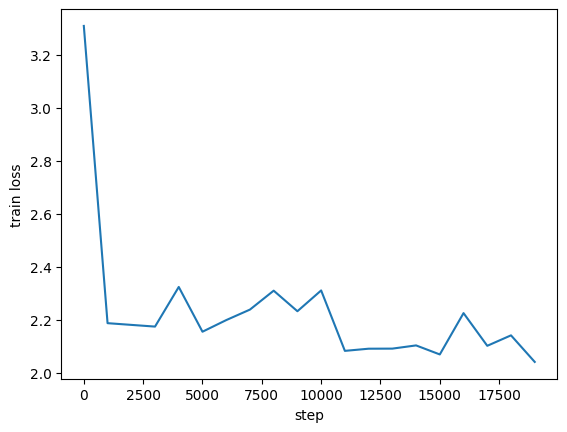

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([eval_interval*i for i in range(len(lossi))], lossi)
plt.xlabel("step")
plt.ylabel("train loss")
plt.show()

In [19]:
@torch.no_grad()
def sample(model_forward, num_samples: int = 20, max_len: int = 20):
    samples = []

    for _ in range(num_samples):
        context = [0] * block_size  # start with '...'
        name = ""

        while True:
            x = torch.tensor([context], device=device)  # (1, block_size)
            logits = model_forward(x)                  # (1, vocab_size)
            probs = torch.softmax(logits, dim=1)       # (1, vocab_size)

            ix = torch.multinomial(probs, num_samples=1).item()
            if ix == 0:
                break

            name += itos[ix]
            context = context[1:] + [ix]

            if len(name) >= max_len:
                break

        samples.append(name)

    return samples

In [21]:
names = sample(forward, num_samples=20)
for n in names:
    print(n)

ozmianori
kawn
niel
core
asting
tiy
kabse
hoxabde
aan
roleiarisaleigh
chey
kdonn
elie
adon
prin
evion
rhakyra
ryla
kaliyah
nolana


In [22]:
@torch.no_grad()
def sample_with_temperature(model_forward, temperature=1.0, num_samples=20):
    samples = []

    for _ in range(num_samples):
        context = [0] * block_size
        name = ""

        while True:
            x = torch.tensor([context], device=device)
            logits = model_forward(x) / temperature
            probs = torch.softmax(logits, dim=1)

            ix = torch.multinomial(probs, 1).item()
            if ix == 0:
                break

            name += itos[ix]
            context = context[1:] + [ix]

        samples.append(name)

    return samples

In [24]:
for t in [0.7, 1.0, 1.3]:
    print(f"\nTemperature = {t}")
    for n in sample_with_temperature(forward, temperature=t, num_samples=5):
        print(n)


Temperature = 0.7
zamae
tan
garrosahanni
lyn
cedoralemil

Temperature = 1.0
nareli
stanna
talyson
eph
tia

Temperature = 1.3
trmien
aowi
makchariussinna
ziherpqdiaryndkengmilee
aaduvackeer


In [25]:
test_loss = split_loss(Xte, Yte)
print(f"test loss: {test_loss:.4f}")

test loss: 2.1885
